# Augmentation Pipeline

Pipeline to generate augmented images and corresponding labels based on oriented bounding boxes in YOLO-format. So far, it only deals with single-class object detection.

## Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2
#automatically reload any imported modules when you re-run a cell

In [2]:
import cv2
import albumentations as A
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils import *

/opt/dacam/user_envs/werm_st/envs2021.05/stella250116/lib/python3.12/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno 101] Network is unreachable>
  data = fetch_version_info()


In [7]:
data_dir = "./exmaple_data" ##folder to data
aug_suffix = "aug" ##suffix for data-saving

In [4]:
example_image_id = 'example1_000001'

### Utiliy Functions for Loading & Plotting

In [ ]:
def get_image_and_label_paths(data_dir, image_id):
    """ Returns dictionary with image file path and label file path for a given image_id.
    
    Parameters
    ----------
    data_dir: string
        path to dataset, e.g. "/home/user/fisheye_data/"
    image_id: string
        image identifier, e.g. "ownrec1_000001"
    
    Returns
    -------
    dict
        image_path and label_path

    Raises
    ------
    ValueError
        If image_id has invalid format.
    FileNotFoundError
        If image or label file does not exist. 
    """
    match = re.match(r'(.+)_\d{6}(?:_\d{3})?$', image_id)
    if not match:
        raise ValueError(f"Invalid image_id format: {image_id}")
    subset_dir = match.group(1)

    # Image path (check both jpg, PNG and png)
    for ext in ['.jpg', '.PNG', '.png']:
        image_path = os.path.join(data_dir, 'images', subset_dir, f'{image_id}{ext}')
        if os.path.exists(image_path):
            break
    else:
        raise FileNotFoundError(f"Image file not found for {image_id} in {data_dir}/images/{subset_dir}")

    # Label path
    label_path = os.path.join(data_dir, 'labels', subset_dir, f'{image_id}.txt')
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label file not found for {image_id} in {label_path}")

    return {'image_path': image_path, 'label_path': label_path}

In [ ]:
def get_image_size(image_path):
    """ Returns height and width of image.
    
    Parameters
    ----------
    image_path: string
        path to image, e.g. "/home/user/fisheye_data/images/dir1/dir1_0001.png"
    
    Returns
    -------
    int, int
        height, width

    Raises
    ------
    FileNotFoundError
        If image does not exist. 
    """
    if os.path.exists(image_path):
        image = cv2.imread(image_path)
        image_height, image_width = image.shape[:2]
    else:
        raise FileNotFoundError(f"Image file not found in {image_path}")
    return image_height, image_width

In [ ]:
def scaled_bbox_from_file(label_path, image_height, image_width):
    """ Load bounding boxes from label file and scale them to image dimensions.

    Parameters
    ----------
    label_path: string
        path to label-file, e.g. "/home/user/fisheye_data/labels/dir1/dir1_0001.txt"
    image_height: int
        height of image in pixels
    image_widht: int
        width of image in pixels
    
    Returns
    -------
    list of list of tuple
        list of bounding boxes; each bounding box is a list of four (x, y) coordinates: [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
        
    """
    bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            coords = list(map(float, line.split()[1:]))  # Extract x1, y1, ..., x4, y4
            keypoints = [(int(coords[i] * image_width), int(coords[i + 1] * image_height)) for i in range(0, 8, 2)] #scale from normalized coordinates to image dimensions 
            bboxes.append(keypoints)            
    return bboxes

In [ ]:
def visualize_image_with_bbox(image_array, bboxes, show=True):
    """ Visualize a single image with overlaid OBB bounding boxes.

    Parameters
    ----------
    image_array: np.ndarray
        Image array (without bounding boxes drawn).
    bboxes: list of list of tuple
        list of bounding boxes; each bounding box is a list of four (x, y) coordinates
    show : bool, optional
        Whether to display the image plot. Default is True.
    
    Returns
    -------
    np.ndarray
        Image array with bounding boxes drawn.
    
    Raises
    ------
    ValueError
        If a bounding box has an unexpected shape.
    """
    image = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        coords = np.array(bbox)
        if coords.shape!=(4,2):
            raise ValueError(f'Bounding Box has wrong shape: {coords.shape}')
        else:
            cv2.polylines(image, [coords], isClosed=True, color=(0, 255, 255), thickness=3)

    if show:
        plt.figure(figsize=(5, 5))
        plt.axis("off")
        plt.imshow(image)
        plt.show()
    return image

In [ ]:
def visualize_image_ids(data_dir, image_ids):
    """ Visualize a collage of single or multiple image_ids.
    Only works, if images and labels are saved!

    Parameters
    ----------
    data_dir: string
        path to dataset, e.g. "/home/user/fisheye_data/"
    image_ids: list
        List of image_ids.

    Returns
    -------
    no returns
    
    """
    
    num_images = len(image_ids)
    columns = min(4, num_images)  # limit max columns to avoid tiny subplots
    rows = math.ceil(num_images / columns)
    
    fig, axs = plt.subplots(rows, columns, figsize=(2 * columns, 2 * rows))
    axs = axs.flatten() if num_images > 1 else [axs]
    
    for i, image_id in enumerate(image_ids):
        paths = get_image_and_label_paths(data_dir, image_id)
        image_path = paths["image_path"]
        label_path = paths["label_path"]
    
        h, w = get_image_size(image_path)
        bboxes = scaled_bbox_from_file(label_path, h, w)
    
        image = cv2.imread(image_path)
        image = visualize_image_with_bbox(image, bboxes, show=False)
    
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(image_id, fontsize=7)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
        
    plt.tight_layout()
    plt.show()

### Utils Functions for Augmentation & Saving

In [ ]:
def apply_transformation(image_array, bboxes, transform):
    """ Transforms image and bounding box.
    
    Parameters
    ----------
    image_array: np.ndarray
        Image array of original image.
    bboxes: list of list of tuple
        list of bounding boxes; each bounding box is a list of four (x, y) coordinates
    transform: albumentations.core.composition.Compose
        Compose of Albumentations transformations
        
    Returns
    -------
    np.ndarray
        Image array of transformed image.
    np.ndarray
        Array of transformed bounding boxes.

    """  
    # Load and flatten keypoints
    keypoints_flat = list(chain.from_iterable(bboxes))

    # Apply augmentations
    transformed = transform(image=image_array, keypoints=keypoints_flat)
    transformed_image = transformed["image"]
    transformed_keypoints = transformed["keypoints"]
    
    # Re-group keypoints into 4-point polygons
    regrouped_keypoints = [transformed_keypoints[i:i + 4] for i in range(0, len(transformed_keypoints), 4)]
    transformed_bboxes = [np.array(box, dtype=np.int32).reshape((4, 2)) for box in regrouped_keypoints]
    
    return transformed_image, transformed_bboxes

In [ ]:
def convert_to_yolo_obb(bboxes, image_height,  image_width, class_id=0):
    """ Normalize bounding box coordinates for YOLO-OBB format.

    Parameters
    ----------
    bboxes: np.ndarray
        Array of bounding boxes coordinates.
    image_height: int
        height of image in pixels
    image_widht: int
        width of image in pixels
    class_id: int, optional
        Class label for all bounding boxes. Default is 0.
    
    Returns
    -------
    list:
        List with one string per line for a yolo-obb-format txt-label file.    
    """
    yolo_obb_lines = []
    
    for box in bboxes:
        normalized_points = []
        for x, y in box:
            x_norm = x / image_width
            y_norm = y / image_height
            normalized_points.extend([x_norm, y_norm])
            
        yolo_line = f"{class_id} " + " ".join(f"{coord:.6f}" for coord in normalized_points)
        yolo_obb_lines.append(yolo_line)

    return yolo_obb_lines


In [ ]:
def save_augmented_image_and_label(data_dir, aug_suffix, image_id, transformation_index, transformed_image, yolo_obb_lines):
    """
    Saves an augmented image and label-file to a corresponding directory for augmented files and return information about these files.

    Parameters
    ----------
    data_dir: string
        path to dataset, e.g. "/home/user/fisheye_data/"
    aug_suffix: string
        suffix for direcotry and file names
    image_id: string
        image identifier, e.g. "ownrec1_000001"
    transformation_index: int
        index of transformation of this single image
    transformed_image: np.ndarray
        Image array of original image.
    yolo_obb_lines: list of strings
        List with one string per line for a yolo-obb-format txt-label file.
    
    Returns
    -------
     dict
        new image_id, image_path and label_path
    """
    # Extract subset name from image_id (e.g. 'ownrec1' from 'ownrec1_000001')
    match = re.match(r'(.+?)_\d{6}$', image_id)
    if not match:
        raise ValueError(f"Invalid image_id format: {image_id}")
    subset_name = match.group(1)
    augmented_subset = f"{subset_name}_{aug_suffix}"

    # Create new image_id
    new_image_id = f"{augmented_subset}_{image_id[-6:]}_{transformation_index:03}"

    # Save image
    image_output_dir = os.path.join(data_dir, "images", augmented_subset)
    os.makedirs(image_output_dir, exist_ok=True)
    image_path = os.path.join(image_output_dir, f"{new_image_id}.PNG")
    #Image.fromarray(transformed_image).save(image_path)
    cv2.imwrite(image_path, transformed_image)
    
    # Save label
    label_output_dir = os.path.join(data_dir, "labels", augmented_subset)
    os.makedirs(label_output_dir, exist_ok=True)
    label_path = os.path.join(label_output_dir, f"{new_image_id}.txt")
    with open(label_path, "w") as f:
        f.write("\n".join(yolo_obb_lines))

    return {'image_id': new_image_id, 'image_path': image_path, 'label_path': label_path}

In [ ]:
def augmentation_saving_pipeline(data_dir, aug_suffix, image_id, number_transformations, transform):
    """
    Full augmentation pipeline including saving for a single image_id.

    Parameters
    ----------
    data_dir: string
        path to dataset, e.g. "/home/user/fisheye_data/"
    aug_suffix: string
        suffix for direcotry and file names
    image_id: string
        image identifier, e.g. "ownrec1_000001"
    number_transformations: int
        number of transformation to execute
    transform: albumentations.core.composition.Compose
        Compose of Albumentations transformations

    Returns
    -------
     list
        list of strings with new image_id's
    """
    paths = get_image_and_label_paths(data_dir=data_dir, image_id=image_id)
    image_path = paths["image_path"]
    label_path = paths["label_path"]
    
    image_array = cv2.imread(image_path)
    h, w = get_image_size(image_path)
    bboxes = scaled_bbox_from_file(label_path, h, w)
    
    transformed_ids = []
    for i in range(number_transformations):
        transformed_image, transformed_bboxes = apply_transformation(image_array, bboxes, transform)
        transformed_height, transformed_width, _ = transformed_image.shape
        yolo_obb_lines = convert_to_yolo_obb(bboxes=transformed_bboxes, image_height=transformed_height, image_width=transformed_width)
        transformed_id = save_augmented_image_and_label(data_dir=data_dir, aug_suffix=aug_suffix, image_id=image_id, transformation_index=i, transformed_image=transformed_image, yolo_obb_lines=yolo_obb_lines)
        transformed_ids.append(transformed_id['image_id'])
    return transformed_ids

### Utily Function for Batch Augmentation

In [ ]:
def get_random_image_ids(dirs, percentage):
    """ Randomly selects a given percentage of images_ids from each directory.
    
    Parameters
    ----------
    dirs: list
        list with strings to image-directories, e.g. "/home/user/fisheye_data/images/ownrec1"
    percentage: int
        percentage of all images in directories to select
    
    Returns
    -------
    list
        list of strings of randomly selected image_ids

    Raises
    ------
    ValueError
        If percentage is not between 0 and 100.
    FileNotFoundError
        If one of the directories is not found, or if it has no image-file of the type PNG or JPEG.
    """
    if not (0 < percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")

    selected_ids = []

    for directory in dirs:
        if not os.path.isdir(directory):
            raise FileNotFoundError(f"Directory not found: {directory}")
        
        # Collect files with all supported extensions
        image_files = []
        for ext in ['*.jpg', '*.PNG', '*.png']:
            image_files.extend(glob(os.path.join(directory, ext)))

        if not image_files:
            raise FileNotFoundError(f"No image files found in directory: {directory}")
            
        # Extract image IDs without extension
        image_ids = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
        
        # Shuffle and select 50%
        k = max(1, int(len(image_ids) * (percentage / 100.0)))
        selected = random.sample(image_ids, k)
        selected_ids.extend(selected)

    return selected_ids

## Define Augmentations

In [5]:
transform = A.Compose(
    [  A.Resize(width=640, height=640),
        ### Geometric Invariance
        A.Resize(width=640, height=640),
        A.Affine(scale=[1,1.2], rotate=[0,90], shear=0, translate_percent=0, keep_ratio=True, p=0.5),
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT), #border to be black       
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        
        ### Occlusion
        A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25),
                    hole_width_range=(0.1, 0.25), fill_value=0, p=0.5),
     
        ### ChannelDropout/Greyscale
        A.OneOf([
            A.ToGray(p=1.0), # p=1.0 inside OneOf
            A.ChannelDropout(p=1.0) # p=1.0 inside OneOf
        ], p=0.2),
        
        ### Color Variation
        A.OneOf([A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),            
                 A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),            
                 A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.8),            
                 A.RandomGamma(gamma_limit=(80, 120), p=0.8),        
                ], p=0.7),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False) #remove_invisible=False stellt sicher, dass auf keinem Fall Koordinaten verloren gehen und so die Reihenfolge korrekt bleibt
)

## Exmaple with single image

### Load Example Image & Label

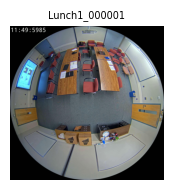

In [8]:
visualize_image_ids(data_dir, [example_image_id])

### Apply augmentation one time and visualize

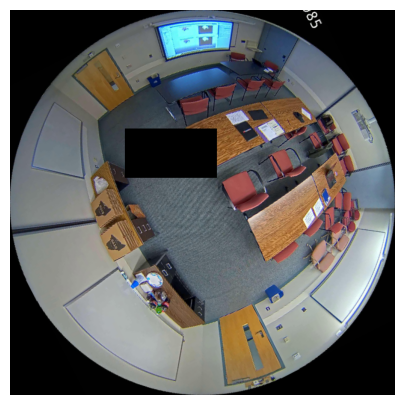

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [9]:
# Get paths for image_id
paths = get_image_and_label_paths(data_dir=data_dir, image_id=example_image_id)
example_image_path = paths["image_path"]
example_label_path = paths["label_path"]

# Read image as array and bboxes
image_array = cv2.imread(example_image_path)
h, w = get_image_size(example_image_path) #needed to scale bbox
bboxes = scaled_bbox_from_file(example_label_path, h, w)

# Apply transformation
transformed_image, transformed_bboxes = apply_transformation(image_array, bboxes, transform)

# Visualize
visualize_image_with_bbox(transformed_image, transformed_bboxes, show=True)

### Apply augmentation multiple times and visualize

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 53.50it/s]


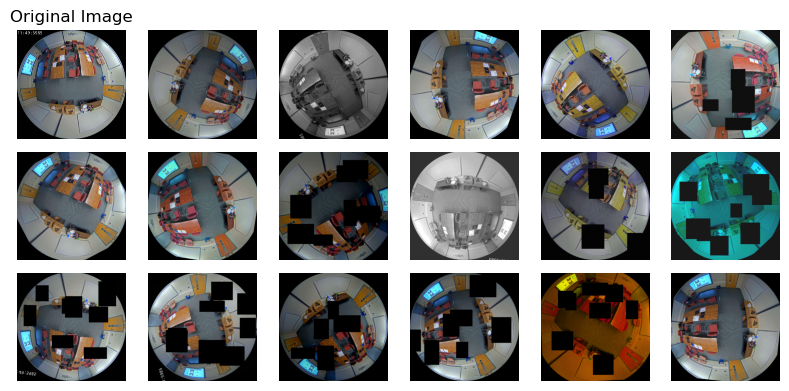

In [10]:
fig = plt.figure(figsize=(8,4))
columns = 6
rows = 3

# Plot original image.
img = visualize_image_with_bbox(image_array, bboxes, show=False)
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

for i in tqdm(range(2, columns*rows+1)):
    #transform image multiple times
    transformed_image, transformed_bboxes = apply_transformation(image_array, bboxes, transform)
    img = visualize_image_with_bbox(transformed_image, transformed_bboxes, show=False)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
#plt.savefig('tranformation-samples.png', bbox_inches='tight')
plt.show()    

## Pipeline: Single Image Id (Augmentation + Saving)

### Visualize Saved Images & Labels
The images and labels are loaded again from disk, where they were saved in the step before. The visualization is to double check, that the saving worked as expected.

In [11]:
image_ids = augmentation_saving_pipeline(data_dir=data_dir, aug_suffix=aug_suffix, image_id=example_image_id, number_transformations=3, transform=transform)

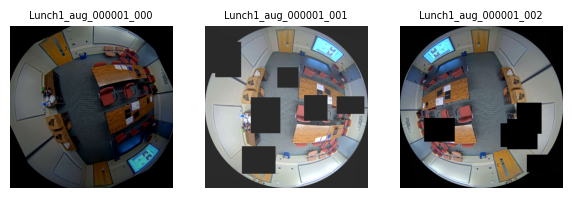

In [12]:
visualize_image_ids(data_dir, image_ids)

## Pipeline: Multiple Image Ids

We randomly select image_ids from a selection of directories.

In [13]:
dirs = [f'{data_dir}/images/example1', f'{data_dir}/images/example2'] #List with paths to the different subsets.
random_ids = get_random_image_ids(dirs=dirs, percentage=100) #percentage of how many of all images from each subset to select (1-100)
print(f'randomly selected {len(random_ids)} image_ids to transform now')

randomly selected 51 image_ids to transform now


In [14]:
random_ids

['Lunch1_001021',
 'Lunch1_000482',
 'Lunch1_000483',
 'Lunch1_000182',
 'Lunch1_000009',
 'Lunch1_000831',
 'Lunch1_000589',
 'Lunch1_000780',
 'Lunch1_000936',
 'Lunch1_000777',
 'Lunch1_000357',
 'Lunch1_000277',
 'Lunch2_001395',
 'Lunch2_002674',
 'Lunch2_002863',
 'Lunch2_002736',
 'Lunch2_001200',
 'Lunch2_002106',
 'Lunch2_000216',
 'Lunch2_002124',
 'Lunch2_002978',
 'Lunch2_000472',
 'Lunch2_002987',
 'Lunch2_002636',
 'Lunch2_000972',
 'Lunch2_000823',
 'Lunch2_002886',
 'Lunch2_000928',
 'Lunch2_002318',
 'Lunch2_001567',
 'Lunch2_000435',
 'Lunch2_001975',
 'Lunch2_000539',
 'Lunch2_000529',
 'Lunch2_001551',
 'Lunch2_001579',
 'Lunch2_001437',
 'Lunch2_001118',
 'Lunch2_001549',
 'Lunch2_000958',
 'Lunch2_001791',
 'Lunch2_001012',
 'Lunch3_000783',
 'Lunch3_000160',
 'Lunch3_000582',
 'Lunch3_000461',
 'Lunch3_000726',
 'Lunch3_000161',
 'Lunch3_000668',
 'Lunch3_000147',
 'Lunch3_000661']

Now we use the full augmentation & saving pipeline to transform each of the randomly selected images a set number of times, save the resulting images and labels and record the image_ids of these transformed images to plot in the second step.

In [15]:
transformed_ids_plotlist = [] #new image_id's to plot later (hence the name "plotlist")
for image_id in tqdm(random_ids):
    transformed_ids = augmentation_saving_pipeline(data_dir=data_dir, aug_suffix=aug_suffix,
                                                   image_id=image_id, 
                                                   number_transformations=3, transform=transform)
    transformed_ids_plotlist.extend([image_id]) #include the original image_id as well as comparison in final plot
    transformed_ids_plotlist.extend(transformed_ids)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.45it/s]


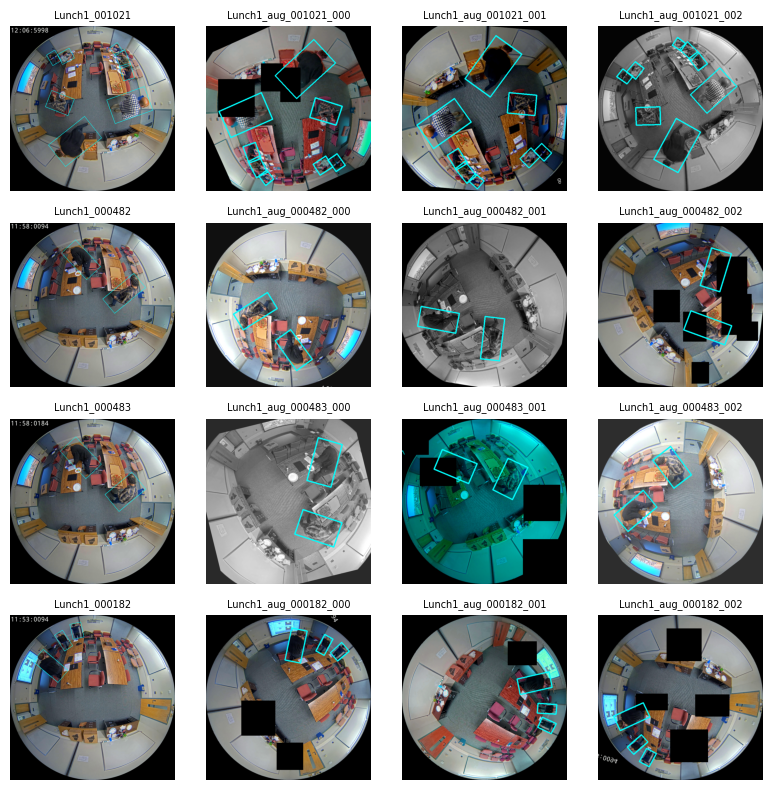

In [16]:
visualize_image_ids(data_dir, transformed_ids_plotlist[:4*4],) #save_path='a17_trainingsample.png'